# 客户价值分析 (RFM模型 + K-Means聚类)

本 Notebook 使用 RFM 模型和 K-Means 聚类算法对客户进行价值分析。
主要步骤包括：
1.  **数据加载与预处理**: 读取销售数据，清洗，处理数据类型。
2.  **计算 RFM 指标**: 计算每个客户的 Recency, Frequency, Monetary 值。
3.  **数据标准化**: 对 RFM 指标进行标准化，消除量纲影响。
4.  **K-Means 聚类**: 使用肘部法则和轮廓系数确定最佳 K 值，并进行聚类。
5.  **聚类结果评价**: 分析聚类效果和各簇特征。
6.  **结果可视化**: 使用图表展示聚类结果。
7.  **结果解读**: 根据聚类特征对客户群体进行划分和解读。

**请确保已安装必要的库:**

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Matplotlib 中文显示设置 ---
# 指定默认字体为黑体 (或其他支持中文的字体，如 Microsoft YaHei, SimHei)
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

print("库导入完成，中文显示已设置。")

库导入完成，中文显示已设置。


## 1. 数据加载与预处理

-   读取指定的 Excel 文件。
-   **重要:** 请在下方代码单元格中将 `'你的数据文件路径.xlsx'` 修改为你的实际文件路径。
-   选择 RFM 分析所需的列，并重命名。
-   进行数据清洗：处理缺失值、转换数据类型（日期、金额）。
-   移除无效数据（如金额小于等于0的记录）。

In [4]:
# --- 1. 数据加载与预处理 ---
print("--- 1. 数据加载与预处理 ---")

# **重要:** 请将 '你的数据文件路径.xlsx' 替换为你的实际文件路径
file_path = '实验二.xlsx' # <--- 修改这里

df = None # 初始化df，避免后续引用未定义变量

try:
    # 读取Excel文件，可以指定sheet_name如果不在第一个sheet
    df_raw = pd.read_excel(file_path)
    print(f"成功读取文件: {file_path}")
    print("原始数据前5行:")
    print(df_raw.head())
    print("\n原始数据信息:")
    df_raw.info()

    # 选择RFM分析所需列，并重命名为英文，方便处理
    # 注意：这里根据你提供的列名选择，请确保列名完全匹配
    relevant_cols = {
        '买家会员名': 'CustomerID',
        '订单创建时间': 'OrderDate',
        '买家实际支付金额': 'Amount'
        # 如果有唯一的订单ID列，也可以加入用于计算频次，例如 '订单编号': 'OrderID'
    }

    # 检查所需列是否存在
    missing_cols = [col for col in relevant_cols.keys() if col not in df_raw.columns]
    if missing_cols:
        raise ValueError(f"错误：数据文件中缺少以下必需列: {', '.join(missing_cols)}")

    df = df_raw[list(relevant_cols.keys())].copy()
    df.rename(columns=relevant_cols, inplace=True)
    print("\n已选择并重命名列。")

    # --- 数据清洗 ---
    print("\n开始数据清洗...")
    initial_rows = len(df)

    # 删除CustomerID或Amount为空的行
    df.dropna(subset=['CustomerID', 'Amount'], inplace=True)
    print(f"删除 CustomerID 或 Amount 为空的行后，剩余: {len(df)} 行")

    # 转换数据类型
    # 将OrderDate转换为datetime对象，忽略无法转换的错误
    df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')
    # 删除OrderDate转换失败的行
    df.dropna(subset=['OrderDate'], inplace=True)
    print(f"处理 OrderDate 类型并删除无效日期后，剩余: {len(df)} 行")

    # 将Amount转换为数值类型，处理可能存在的非数值（如'元'）
    if df['Amount'].dtype == 'object':
        # 尝试去除 '元' 等非数字字符，然后转换
        print("Amount 列为 object 类型，尝试去除'元'并转换为数值...")
        df['Amount'] = df['Amount'].astype(str).str.replace('元', '', regex=False).str.strip()
        df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
    elif not pd.api.types.is_numeric_dtype(df['Amount']):
         print("Amount 列非数值类型，尝试直接转换为数值...")
         df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
    else:
        print("Amount 列已是数值类型。")


    # 删除Amount转换失败或小于等于0的行 (通常消费金额>0)
    df.dropna(subset=['Amount'], inplace=True)
    df = df[df['Amount'] > 0]
    print(f"处理 Amount 类型并删除无效金额后，剩余: {len(df)} 行")

    print(f"\n数据清洗完成。总共移除 {initial_rows - len(df)} 行无效数据。")

    print("\n预处理后数据前5行:")
    print(df.head())
    print("\n预处理后数据信息:")
    df.info()
    print(f"预处理后最终有效记录数: {len(df)}")

    if df.empty:
        raise ValueError("错误：预处理后没有有效数据，请检查原始数据和预处理步骤。")

except FileNotFoundError:
    print(f"错误：文件未找到，请检查路径 '{file_path}' 是否正确。")
except ValueError as ve:
    print(ve)
except Exception as e:
    print(f"读取或预处理数据时发生未知错误: {e}")

# 如果 df 成功加载和预处理，显示成功消息
if df is not None and not df.empty:
    print("\n--- 数据加载与预处理阶段成功完成 ---")
elif df is None:
     print("\n--- 数据加载与预处理阶段失败，请检查错误信息 ---")

--- 1. 数据加载与预处理 ---
成功读取文件: 实验二.xlsx
原始数据前5行:
           买家会员名  买家实际支付积分  买家实际支付金额  买家应付货款  买家应付邮费              买家支付宝账号  \
0         qust99         0    143.64  143.64       0     190414156@qq.com   
1  songjones4000         0     55.86   55.86       0          13224268598   
2          133王超         0     55.86   55.86       0  13283421509@163.com   
3           扛扛大人         0     48.86   48.86       0          18556356916   
4            楠楠途         0      0.00  268.00       0    1031213843@qq.com   

   买家支付积分 买家服务费                                      买家留言  修改后的sku  ... 联系电话   \
0       0    0元  开发票：青岛欧特思自动化科技有限公司，税号：91370213MA3CJTQ95N      NaN  ...   NaN   
1       0    0元                                       NaN      NaN  ...   NaN   
2       0    0元                                       NaN      NaN  ...   NaN   
3       0    0元                                       NaN      NaN  ...   NaN   
4       0    0元                                       NaN      NaN  ...   NaN   

    

d:\environment_variables\Python312\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


## 2. 计算 RFM 指标

-   确定分析的**快照日期 (Snapshot Date)**，通常是数据集中最后一次交易日期加一天。
-   按客户ID (`CustomerID`) 分组。
-   计算每个客户的：
    -   **Recency (R)**: 最近一次消费时间距今的天数（天数越少越好）。
    -   **Frequency (F)**: 统计时间内的消费次数（次数越多越好）。
    -   **Monetary (M)**: 统计时间内的总消费金额（金额越多越好）。
-   将计算结果保存到 CSV 文件。

In [5]:
# --- 2. 计算RFM指标 ---
if df is not None and not df.empty:
    print("\n--- 2. 计算RFM指标 ---")

    # 确定快照日期 (Snapshot Date) - 通常是最后交易日期+1天
    snapshot_date = df['OrderDate'].max() + dt.timedelta(days=1)
    print(f"数据快照日期 (用于计算Recency): {snapshot_date.strftime('%Y-%m-%d')}")

    # 按客户分组计算RFM
    rfm = df.groupby('CustomerID').agg(
        # Recency: 计算最后购买日期与快照日期的天数差
        Recency=('OrderDate', lambda x: (snapshot_date - x.max()).days),
        # Frequency: 计算购买次数 (每个记录算一次购买)
        # 如果你的数据是一行代表一个订单，可以直接用 count
        # 如果你的数据是一行代表一个商品，需要先按订单ID去重再计数，或者直接用 OrderDate count
        Frequency=('OrderDate', 'count'),
        # Monetary: 计算总购买金额
        Monetary=('Amount', 'sum')
    )

    # 查看RFM结果
    print("\n计算得到的RFM值 (前5行):")
    print(rfm.head())
    print("\nRFM数据描述性统计:")
    print(rfm.describe())

    # 将计算好的RFM数据保存到文件 (例如CSV)
    try:
        rfm_output_path = 'rfm_analysis_results.csv'
        rfm.to_csv(rfm_output_path)
        print(f"\nRFM结果已保存到: {rfm_output_path}")
        # 如果需要保存为Excel:
        # rfm_excel_path = 'rfm_analysis_results.xlsx'
        # rfm.to_excel(rfm_excel_path)
        # print(f"RFM结果已保存到: {rfm_excel_path}")
    except Exception as e:
        print(f"保存RFM结果时出错: {e}")

    print("\n--- RFM 指标计算完成 ---")
else:
    print("错误：由于数据加载/预处理失败，无法计算RFM指标。")


--- 2. 计算RFM指标 ---
数据快照日期 (用于计算Recency): 2019-01-01

计算得到的RFM值 (前5行):
                Recency  Frequency  Monetary
CustomerID                                  
00牛哥哥00             694          2    402.00
020luo              409          1     74.70
0587xueguangju      626          1    268.00
0o秋天de童话             83          2    411.50
0残缺0                346          1     48.86

RFM数据描述性统计:
           Recency    Frequency      Monetary
count  1668.000000  1668.000000   1668.000000
mean    321.052758     1.363309    247.362608
std     192.383240     0.867957    561.128350
min       1.000000     1.000000      0.100000
25%     172.000000     1.000000     55.860000
50%     340.000000     1.000000    111.720000
75%     452.500000     1.000000    268.000000
max     728.000000    15.000000  13246.800000

RFM结果已保存到: rfm_analysis_results.csv

--- RFM 指标计算完成 ---


## 3. 数据标准化

-   由于 RFM 三个指标的量纲不同（Recency 是天数，Frequency 是次数，Monetary 是金额），直接聚类可能会使得数值范围大的指标占据主导地位。
-   使用**标准化 (Standardization)**，通常是 Z-score 标准化，将数据转换为均值为0，标准差为1的分布。
-   检查并处理可能存在的无穷大 (`inf`) 或非数字 (`NaN`) 值。

In [6]:
# --- 3. 数据标准化 ---
if 'rfm' in locals() and not rfm.empty:
    print("\n--- 3. 数据标准化 ---")

    # 检查RFM数据是否有inf或NaN（理论上不应有，但以防万一）
    if rfm.isnull().values.any() or np.isinf(rfm.values).any():
        print("警告：RFM数据中存在NaN或Inf值，尝试删除包含这些值的行...")
        initial_count = len(rfm)
        rfm.replace([np.inf, -np.inf], np.nan, inplace=True)
        rfm.dropna(inplace=True)
        print(f"已处理NaN/Inf值。移除了 {initial_count - len(rfm)} 行。")

    if rfm.empty:
        print("错误：标准化前RFM数据为空，无法继续。")
        rfm_scaled_df = None # 确保变量不存在或为空
    else:
        # 提取需要标准化的特征
        rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

        # 使用StandardScaler进行Z-score标准化
        scaler = StandardScaler()
        rfm_scaled = scaler.fit_transform(rfm_features)

        # 将标准化后的数据转回DataFrame，方便后续使用
        # 使用原始 rfm DataFrame 的索引
        rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=['R_scaled', 'F_scaled', 'M_scaled'])

        print("\n标准化后的RFM数据 (前5行):")
        print(rfm_scaled_df.head())
        print("\n--- 数据标准化完成 ---")

else:
    print("错误：RFM 数据不存在或为空，无法进行标准化。")
    rfm_scaled_df = None # 确保变量不存在或为空


--- 3. 数据标准化 ---

标准化后的RFM数据 (前5行):
                R_scaled  F_scaled  M_scaled
CustomerID                                  
00牛哥哥00         1.939145  0.733771  0.275666
020luo          0.457283 -0.418705 -0.307798
0587xueguangju  1.585578 -0.418705  0.036789
0o秋天de童话       -1.237759  0.733771  0.292601
0残缺0            0.129714 -0.418705 -0.353862

--- 数据标准化完成 ---


## 4. K-Means 聚类

-   **选择最佳 K 值**:
    -   **肘部法则 (Elbow Method)**: 计算不同 K 值对应的簇内平方和 (WCSS)，寻找 WCSS 下降速率趋于平缓的“肘点”。
    -   **轮廓系数 (Silhouette Score)**: 计算不同 K 值对应的轮廓系数，选择得分最高的 K 值（越接近1越好）。
-   **执行聚类**: 使用选定的 K 值运行 K-Means 算法。
-   将聚类结果（每个客户所属的簇标签）添加到 RFM 数据中。


--- 4.1 寻找最优 K 值 ---
K=2, WCSS=3828.04, Silhouette Score=0.3951
K=3, WCSS=2718.45, Silhouette Score=0.4112
K=4, WCSS=1787.74, Silhouette Score=0.4186
K=5, WCSS=1474.27, Silhouette Score=0.3980
K=6, WCSS=1210.69, Silhouette Score=0.4515
K=7, WCSS=1022.15, Silhouette Score=0.4698
K=8, WCSS=848.11, Silhouette Score=0.4722
K=9, WCSS=719.19, Silhouette Score=0.5000
K=10, WCSS=658.58, Silhouette Score=0.4632


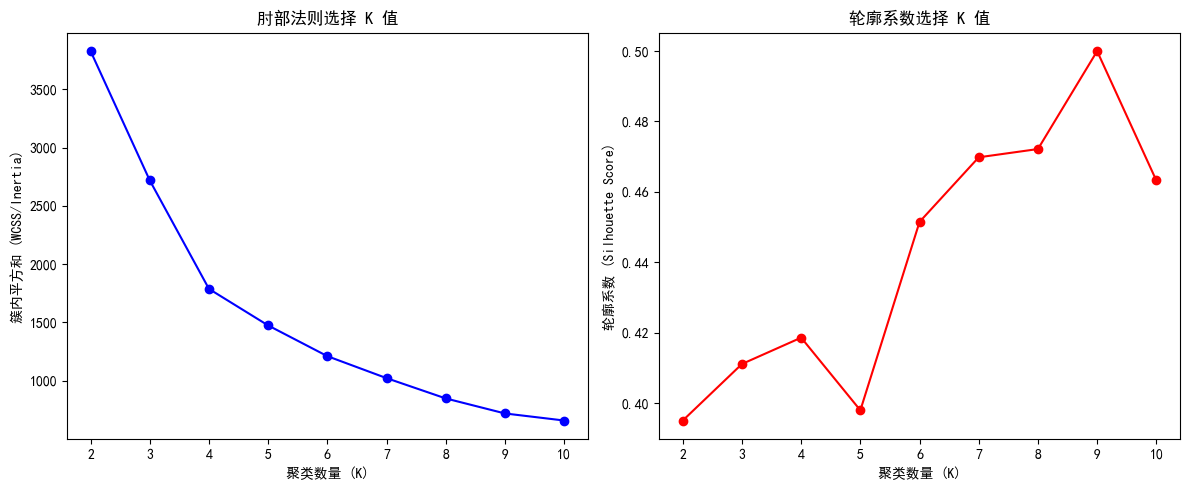


请观察上方图形：
 - 肘部法则：寻找 WCSS 下降趋于平缓的 '肘点' K值。
 - 轮廓系数：寻找得分最高的 K 值。


In [7]:
# --- 4. K-Means聚类 ---
# 4.1 选择最优K值 (肘部法则 和 轮廓系数)

if rfm_scaled_df is not None and not rfm_scaled_df.empty:
    print("\n--- 4.1 寻找最优 K 值 ---")
    inertia = [] # WCSS (Within-Cluster Sum of Squares)
    silhouette_scores = []
    k_range = range(2, 11) # 尝试聚类数量从2到10

    for k in k_range:
        # 使用 n_init='auto' 或 n_init=10 来避免警告，random_state保证结果可复现
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(rfm_scaled_df)
        inertia.append(kmeans.inertia_)
        # 轮廓系数需要至少2个簇
        score = silhouette_score(rfm_scaled_df, kmeans.labels_)
        silhouette_scores.append(score)
        print(f"K={k}, WCSS={kmeans.inertia_:.2f}, Silhouette Score={score:.4f}")

    # --- 绘制肘部法则图和轮廓系数图 ---
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertia, 'bo-')
    plt.xlabel('聚类数量 (K)')
    plt.ylabel('簇内平方和 (WCSS/Inertia)')
    plt.title('肘部法则选择 K 值')
    plt.xticks(k_range) # 确保x轴刻度清晰

    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'ro-')
    plt.xlabel('聚类数量 (K)')
    plt.ylabel('轮廓系数 (Silhouette Score)')
    plt.title('轮廓系数选择 K 值')
    plt.xticks(k_range) # 确保x轴刻度清晰

    plt.tight_layout()
    plt.show()

    print("\n请观察上方图形：")
    print(" - 肘部法则：寻找 WCSS 下降趋于平缓的 '肘点' K值。")
    print(" - 轮廓系数：寻找得分最高的 K 值。")

else:
    print("错误：标准化的 RFM 数据不存在或为空，无法进行 K 值选择。")

### 4.2 选择并设定 K 值

**根据上面的图形分析结果，在下方代码单元格中设置 `chosen_k` 的值。**

肘部在 K=4 处，并且 K=4 的轮廓系数也相对较高，则可以将 `chosen_k` 设为 4。

In [8]:
# 计算各字段的唯一值数量
chosen_k = 9  # <--- **在这里修改你选择的 K 值**

if 'rfm' in locals() and rfm_scaled_df is not None and not rfm_scaled_df.empty:
    print(f"\n--- 4.3 执行最终 K-Means 聚类 (K = {chosen_k}) ---")

    # 4.3 执行最终的K-Means聚类
    kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
    kmeans_final.fit(rfm_scaled_df)

    # 获取聚类标签
    cluster_labels = kmeans_final.labels_

    # 将聚类标签添加回原始RFM数据框 (确保索引对齐)
    # 因为标准化时可能删除了NaN/Inf行，需要使用 rfm_scaled_df 的索引来匹配
    rfm_clustered = rfm.loc[rfm_scaled_df.index].copy() # 获取与标准化数据对应的原始RFM行
    rfm_clustered['Cluster'] = cluster_labels

    print(f"\n已将客户分配到 {chosen_k} 个簇中 (聚类后 RFM 数据前5行):")
    print(rfm_clustered.head())
    print(f"\n--- K-Means 聚类 (K={chosen_k}) 完成 ---")

else:
    print(f"错误：无法执行最终聚类，因为 RFM 数据或标准化数据准备失败。")
    rfm_clustered = None # 确保变量不存在或为空


--- 4.3 执行最终 K-Means 聚类 (K = 9) ---

已将客户分配到 9 个簇中 (聚类后 RFM 数据前5行):
                Recency  Frequency  Monetary  Cluster
CustomerID                                           
00牛哥哥00             694          2    402.00        5
020luo              409          1     74.70        7
0587xueguangju      626          1    268.00        1
0o秋天de童话             83          2    411.50        6
0残缺0                346          1     48.86        7

--- K-Means 聚类 (K=9) 完成 ---


## 5. 聚类结果评价

-   计算最终选定 K 值下的**轮廓系数**，评价聚类效果的紧密度和分离度。
    -   接近 1: 效果好。
    -   接近 0: 簇重叠或点在边界。
    -   接近 -1: 点可能分错簇。
-   计算每个簇的 **RFM 指标均值**和**客户数量**，以理解每个簇的基本特征。

In [9]:
# --- 5. 聚类结果评价 ---
if rfm_clustered is not None and not rfm_clustered.empty and 'rfm_scaled_df' in locals() and rfm_scaled_df is not None:
    print("\n--- 5. 聚类结果评价 ---")
    final_silhouette_score = silhouette_score(rfm_scaled_df, rfm_clustered['Cluster'])
    print(f"最终聚类 (K={chosen_k}) 的轮廓系数: {final_silhouette_score:.4f}")
    # 轮廓系数解释
    if final_silhouette_score > 0.7:
        print("轮廓系数 > 0.7: 聚类效果非常好，结构清晰。")
    elif final_silhouette_score > 0.5:
        print("轮廓系数 > 0.5: 聚类效果合理。")
    elif final_silhouette_score > 0:
        print("轮廓系数 > 0: 聚类效果一般，可能存在重叠。")
    else:
        print("轮廓系数 <= 0: 聚类效果较差，可能存在较多错误分配或簇结构不明显。")


    # 分析每个簇的RFM均值，理解簇的特征
    cluster_summary = rfm_clustered.groupby('Cluster').agg(
        Recency_Mean=('Recency', 'mean'),
        Frequency_Mean=('Frequency', 'mean'),
        Monetary_Mean=('Monetary', 'mean'),
        Cluster_Size=('Recency', 'count') # 查看每个簇有多少客户
    ).round(2) # 保留两位小数方便查看

    print("\n各簇 RFM 均值及客户数量:")
    # 按消费金额排序，方便识别高价值客户簇
    print(cluster_summary.sort_values(by='Monetary_Mean', ascending=False))

    print("\n--- 聚类结果评价完成 ---")
else:
     print("错误：聚类结果不存在或为空，无法进行评价。")
     cluster_summary = None # 确保变量不存在或为空


--- 5. 聚类结果评价 ---
最终聚类 (K=9) 的轮廓系数: 0.5000
轮廓系数 > 0: 聚类效果一般，可能存在重叠。

各簇 RFM 均值及客户数量:
         Recency_Mean  Frequency_Mean  Monetary_Mean  Cluster_Size
Cluster                                                           
4               87.00            4.00       13003.00             2
8              395.00           15.00        4020.00             1
3              438.39            1.37        1456.52            54
2              289.79            4.58         824.19            53
5              475.02            2.19         328.92           150
6              163.83            2.15         265.47           172
1              574.57            1.00         176.26           306
7              339.96            1.00         119.87           564
0               79.04            1.00         119.41           366

--- 聚类结果评价完成 ---


## 6. 结果可视化

-   **各簇 RFM 均值柱状图**: 直观对比不同簇在 R, F, M 三个维度上的平均表现。
-   **RFM 两两组合散点图**:
    -   Recency vs Frequency
    -   Frequency vs Monetary
    -   (可选) Recency vs Monetary
    用不同颜色表示不同的簇，观察客户在二维空间中的分布。
-   **3D 散点图 (可选)**: 在三维空间中展示 R, F, M 和聚类结果，更全面地观察簇的分布。


--- 6. 结果可视化 ---

--- 6.1 各簇 RFM 均值柱状图 ---


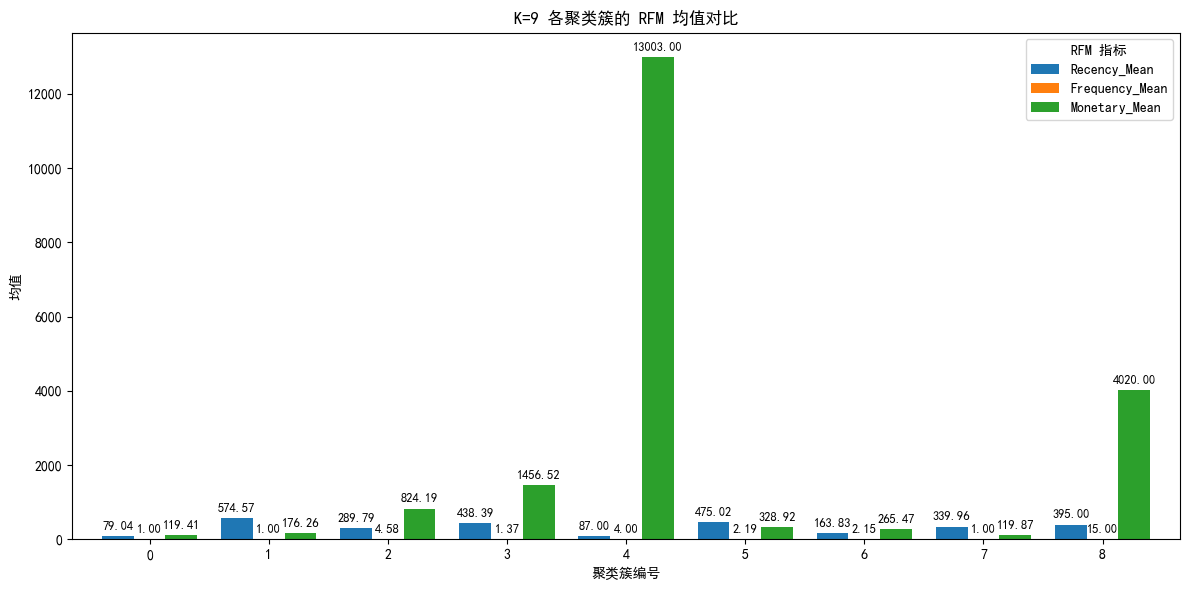

In [10]:
# --- 6. 结果可视化 ---
print("\n--- 6. 结果可视化 ---")

# 6.1 各簇RFM均值柱状图
if 'cluster_summary' in locals() and cluster_summary is not None and not cluster_summary.empty:
    print("\n--- 6.1 各簇 RFM 均值柱状图 ---")
    cluster_summary_plot = cluster_summary[['Recency_Mean', 'Frequency_Mean', 'Monetary_Mean']]

    # 绘制柱状图
    ax = cluster_summary_plot.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.title(f'K={chosen_k} 各聚类簇的 RFM 均值对比')
    plt.ylabel('均值')
    plt.xlabel('聚类簇编号')
    plt.xticks(rotation=0) # 水平显示簇编号
    plt.legend(title='RFM 指标')
    # 在柱子上显示数值
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9, padding=3)
    plt.tight_layout() # 调整布局防止标签重叠
    plt.show()
else:
    print("无法绘制柱状图，因为 cluster_summary 不存在或为空。")


--- 6.2 散点图: Recency vs Frequency ---


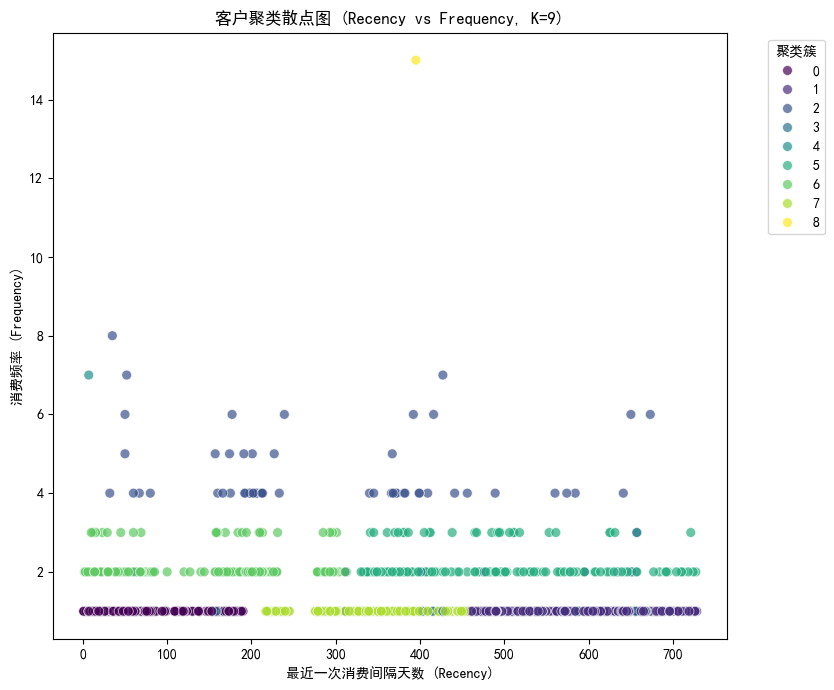

In [11]:
# 6.2 RFM两两组合散点图 (以R和F为例，用颜色区分簇)
if rfm_clustered is not None and not rfm_clustered.empty:
    print("\n--- 6.2 散点图: Recency vs Frequency ---")
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=rfm_clustered, x='Recency', y='Frequency', hue='Cluster',
                    palette='viridis', s=50, alpha=0.7, legend='full')
    plt.title(f'客户聚类散点图 (Recency vs Frequency, K={chosen_k})')
    plt.xlabel('最近一次消费间隔天数 (Recency)')
    plt.ylabel('消费频率 (Frequency)')
    plt.legend(title='聚类簇', bbox_to_anchor=(1.05, 1), loc='upper left') # 将图例放在图外
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # 调整布局给图例空间
    plt.show()
else:
    print("无法绘制 R vs F 散点图，因为 rfm_clustered 不存在或为空。")


--- 6.3 散点图: Frequency vs Monetary ---


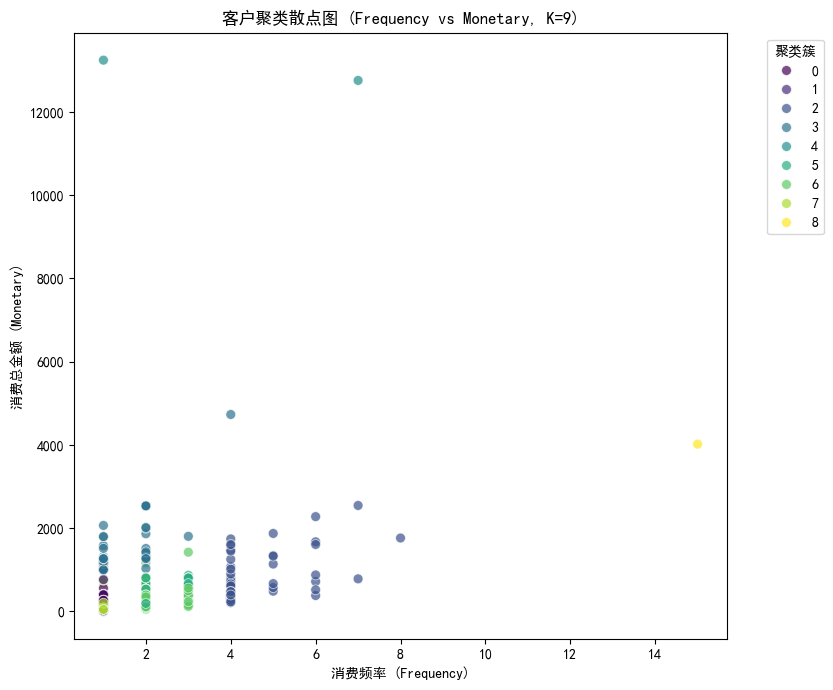

In [12]:
# 6.3 RFM两两组合散点图 (以F和M为例，用颜色区分簇)
if rfm_clustered is not None and not rfm_clustered.empty:
    print("\n--- 6.3 散点图: Frequency vs Monetary ---")
    plt.figure(figsize=(10, 7))
    # 可以对 Monetary 取对数，如果数值范围过大导致难以观察
    # sns.scatterplot(data=rfm_clustered, x='Frequency', y=np.log1p(rfm_clustered['Monetary']), hue='Cluster', ...)
    # plt.ylabel('消费总金额 (Log Transformed Monetary)')
    sns.scatterplot(data=rfm_clustered, x='Frequency', y='Monetary', hue='Cluster',
                    palette='viridis', s=50, alpha=0.7, legend='full')
    plt.title(f'客户聚类散点图 (Frequency vs Monetary, K={chosen_k})')
    plt.xlabel('消费频率 (Frequency)')
    plt.ylabel('消费总金额 (Monetary)')
    plt.legend(title='聚类簇', bbox_to_anchor=(1.05, 1), loc='upper left') # 将图例放在图外
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # 调整布局给图例空间
    plt.show()
else:
    print("无法绘制 F vs M 散点图，因为 rfm_clustered 不存在或为空。")


--- 6.4 可选: 3D 散点图 ---


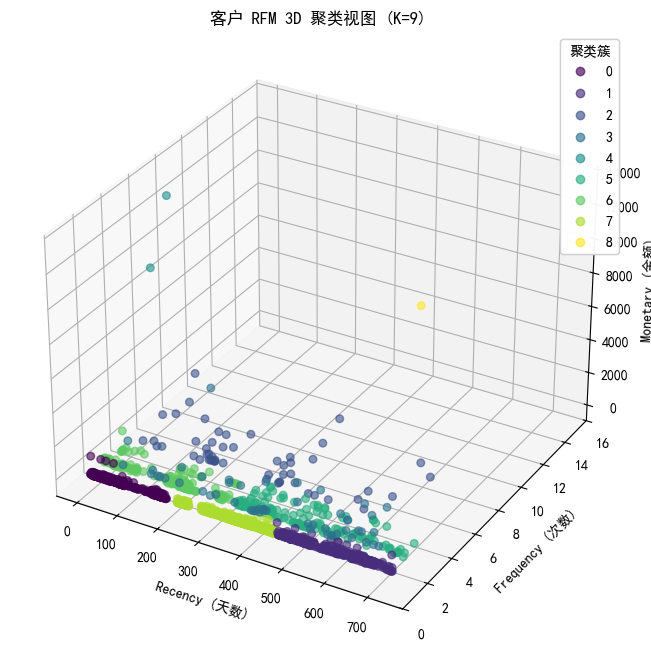

In [13]:
# 6.4 [可选] 3D散点图
if rfm_clustered is not None and not rfm_clustered.empty:
    print("\n--- 6.4 可选: 3D 散点图 ---")
    try:
        from mpl_toolkits.mplot3d import Axes3D # 尝试导入3D绘图工具

        fig = plt.figure(figsize=(10, 8)) # 调整画布大小
        ax = fig.add_subplot(111, projection='3d')

        # 使用 rfm_clustered 数据绘制散点图
        scatter = ax.scatter(rfm_clustered['Recency'], rfm_clustered['Frequency'], rfm_clustered['Monetary'],
                             c=rfm_clustered['Cluster'], cmap='viridis', s=30, alpha=0.6)

        ax.set_xlabel('Recency (天数)')
        ax.set_ylabel('Frequency (次数)')
        ax.set_zlabel('Monetary (金额)')
        ax.set_title(f'客户 RFM 3D 聚类视图 (K={chosen_k})')

        # 添加颜色条图例
        legend1 = ax.legend(*scatter.legend_elements(), title="聚类簇")
        ax.add_artist(legend1)

        # 反转Recency轴，使得更近的点在前面 (可选，根据观察习惯)
        # ax.invert_xaxis()

        plt.show()

    except ImportError:
        print("\n提示：未能导入 mpl_toolkits.mplot3d，无法绘制 3D 散点图。")
        print("如果需要绘制，请确保 matplotlib 已正确安装并包含 3D 工具包。")
    except Exception as e:
        print(f"\n绘制 3D 散点图时出错: {e}")
else:
    print("无法绘制 3D 散点图，因为 rfm_clustered 不存在或为空。")

## 7. 聚类结果解读


假设 `chosen_k = 4`，且 `cluster_summary` 表格显示：

* **簇 0**: Recency 低 (均值小), Frequency 高 (均值大), Monetary 高 (均值大), 客户数量较多 -> **重要价值客户**: 最近刚买过，购买频率高，消费金额高。重点维持，提供 VIP 服务。
* **簇 1**: Recency 低 (均值小), Frequency 低 (均值小), Monetary 低 (均值小), 客户数量最多 -> **潜力新客户/一般客户**: 最近有购买，但频率和金额都不高。可能包含新客户或低价值客户，可以尝试引导复购，提升价值。
* **簇 2**: Recency 高 (均值大), Frequency 低 (均值小), Monetary 低 (均值小), 客户数量较少 -> **低价值流失风险客户**: 很久没来买了，买的次数少，金额也低。可能需要召回策略，或者价值不高可以考虑放弃。
* **簇 3**: Recency 高 (均值大), Frequency 高 (均值大), Monetary 高 (均值大), 客户数量中等 -> **重要挽留客户**: 曾经是高价值客户（高 F, 高 M），但很久没来了（高 R）。需要重点采取措施挽留，防止彻底流失。
